In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Notebook to do time series analysis on crime in San Francisco from 2003 - 2017


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [21]:
# Import and turn date and time into single timestamp and then use resampling for plotting
df = pd.read_csv('../../Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv', 
                  parse_dates={'Datetime': ['Date', 'Time']}, infer_datetime_format=True)

# Show all columns of dataframe
pd.set_option('display.max_columns', None)

Index(['Datetime', 'IncidntNum', 'Category', 'Descript', 'DayOfWeek',
       'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId',
       'SF Find Neighborhoods', 'Current Police Districts',
       'Current Supervisor Districts', 'Analysis Neighborhoods',
       'DELETE - Fire Prevention Districts', 'DELETE - Police Districts',
       'DELETE - Supervisor Districts', 'DELETE - Zip Codes',
       'DELETE - Neighborhoods', 'DELETE - 2017 Fix It Zones',
       'Civic Center Harm Reduction Project Boundary',
       'Fix It Zones as of 2017-11-06 ', 'DELETE - HSOC Zones',
       'Fix It Zones as of 2018-02-07',
       'CBD, BID and GBD Boundaries as of 2017',
       'Areas of Vulnerability, 2016', 'Central Market/Tenderloin Boundary',
       'Central Market/Tenderloin Boundary Polygon - Updated',
       'HSOC Zones as of 2018-06-05', 'OWED Public Spaces'],
      dtype='object')

In [24]:
# Keep columns and sort by date/time
df = df[['Category', 'Descript', 'DayOfWeek', 'Datetime', 'X', 'Y', 'PdDistrict', 'Resolution']]

data = (
    df.dropna()
    .sort_values(by='Datetime')
)

# Set index to datetime object for resampling
data = data.set_index('Datetime')

In [27]:
data.head()

,Category,Descript,DayOfWeek,Datetime,X,Y,PdDistrict,Resolution
1605432,FORGERY/COUNTERFEITING,"FORGERY, FALSE ENTRIES IN RECORDS OR RETURNS",Wednesday,2003-01-01 00:01:00,-122.403405,37.775421,SOUTHERN,NONE
958656,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Wednesday,2003-01-01 00:01:00,-122.424037,37.762751,MISSION,NONE
1504089,NON-CRIMINAL,"DEATH REPORT, CAUSE UNKNOWN",Wednesday,2003-01-01 00:01:00,-122.415065,37.776435,SOUTHERN,NONE
1179147,OTHER OFFENSES,FORTUNE TELLING,Wednesday,2003-01-01 00:01:00,-122.392671,37.782399,SOUTHERN,"ARREST, BOOKED"
1600078,OTHER OFFENSES,OBSCENE PHONE CALLS(S),Wednesday,2003-01-01 00:01:00,-122.500300,37.757847,TARAVAL,NONE


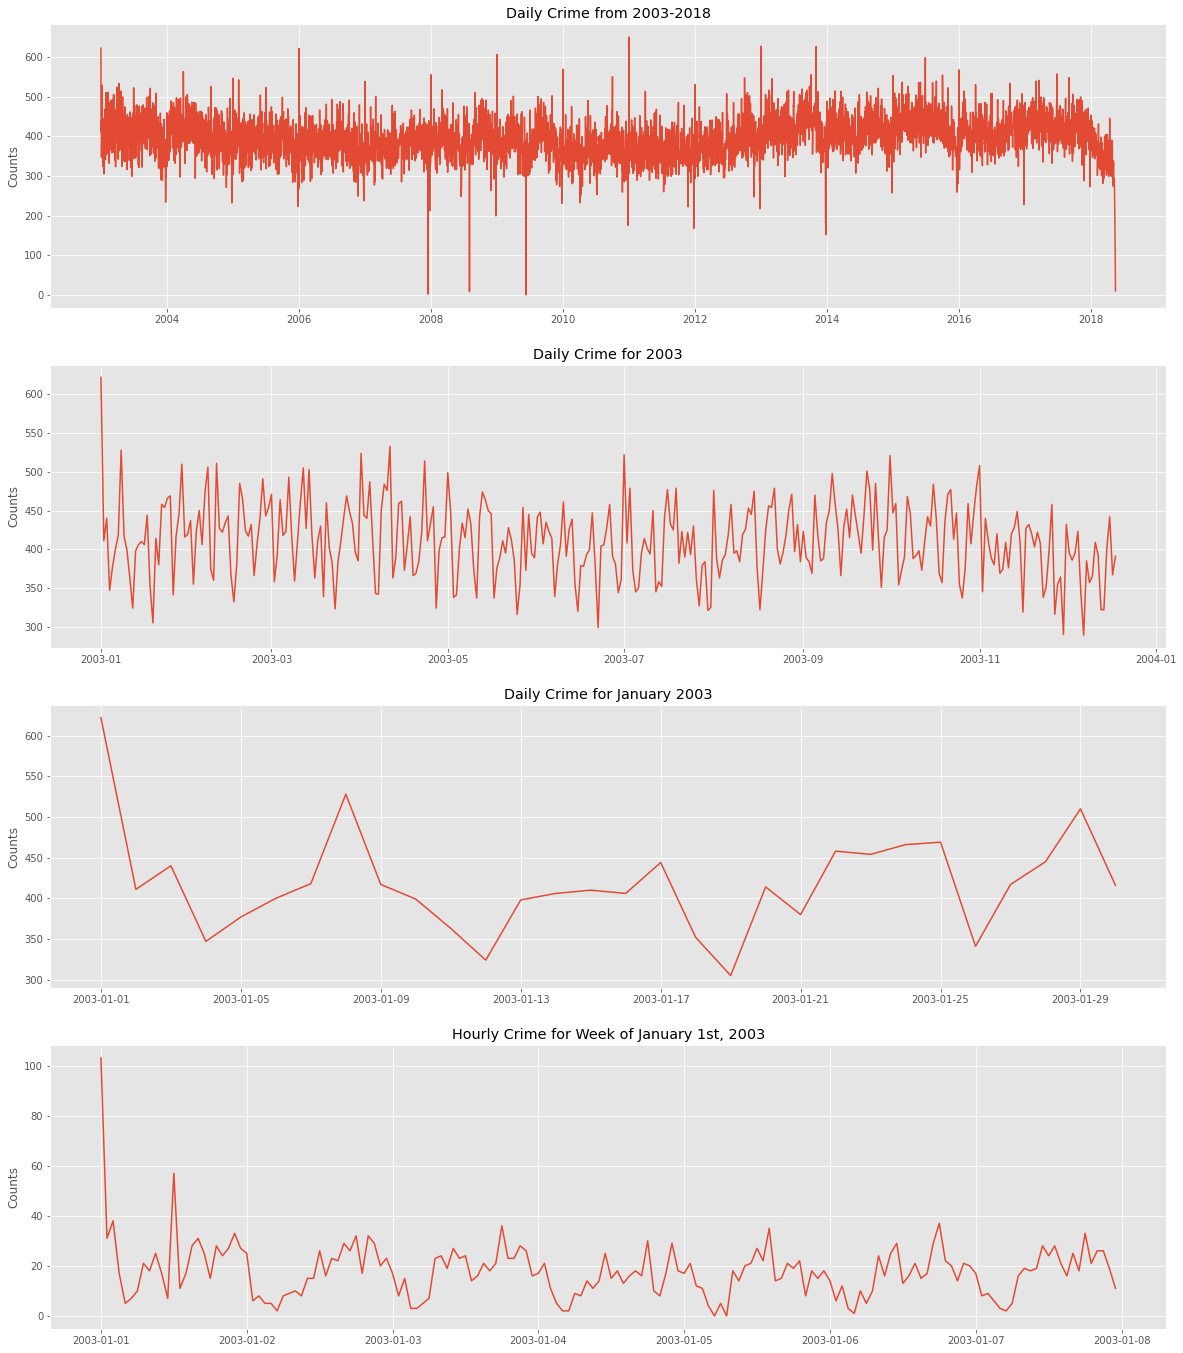

In [52]:
# Plot crimes using resampling
fig, axes = plt.subplots(4, 1, figsize=(20,24))
ax = axes[0]
ax.plot(data.resample('D').count()['Category'])
ax.set_title('Daily Crime from 2003-2018')
ax.set_ylabel('Counts')

ax = axes[1]
ax.plot(data.resample('D').count()['Category'].iloc[0:352])
ax.set_title('Daily Crime for 2003')
ax.set_ylabel('Counts')

ax = axes[2]
ax.plot(data.resample('D').count()['Category'].iloc[0:30])
ax.set_title('Daily Crime for January 2003')
ax.set_ylabel('Counts')

ax = axes[3]
ax.plot(data.resample('H').count()['Category'].iloc[0:168])
ax.set_title('Hourly Crime for Week of January 1st, 2003')
ax.set_ylabel('Counts')

#plt.savefig('../data/images/Crimetrends.png', bbox_inches='tight', dpi=350)

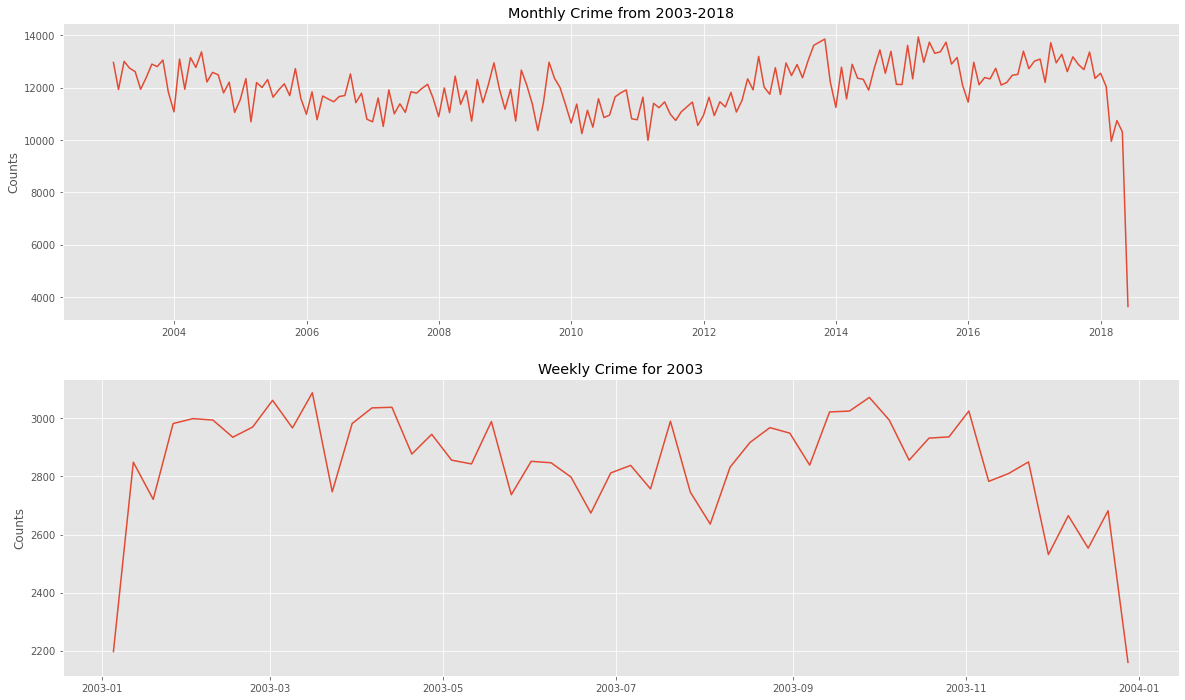

In [54]:
# Breakdown into different timescales
fig, axes = plt.subplots(2, 1, figsize=(20,12))
ax = axes[0]
ax.plot(data.resample('M').count()['Category'])
ax.set_title('Monthly Crime from 2003-2018')
ax.set_ylabel('Counts')

ax = axes[1]
ax.plot(data.resample('W').count()['Category'].iloc[0:52])
ax.set_title('Weekly Crime for 2003')
ax.set_ylabel('Counts')

#plt.savefig('../data/images/Crimetrends2.png', bbox_inches='tight', dpi=350)

In [58]:
# Remove data from 2018 from analysis
data = data.loc[:'2017-12-31']

### Trend Analysis

Looking at the data at various time scales shows that we may have a few different frequency components: weekly and seasonal. Had we looked at the time a crime is commited, we'd likely see a time trand as well (this was seeing during initial EDA). 

We'll likely need to do some resampling of the crime, but for now let's try to decompose the data using trend-season-residual decomposition. 